In [1]:
# Importing the necessary libraries
import platform
print("Python version:", platform.python_version())

import sys
import os

import torch
print("torch version:", torch.__version__)

import numpy as np
print("numpy version:", np.__version__)

import cv2
print("cv2 version:", cv2.__version__)

import matplotlib
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
print("matplotlib version:", matplotlib.__version__)

from PIL import Image

import pandas as pd
print("pandas version:", pd.__version__)

from skimage.transform import resize

import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision.models import inception_v3
from torch.autograd import grad
import torch.nn.functional as F
from scipy.linalg import sqrtm

# Device setup
device = "cuda" if torch.cuda.is_available() else "cpu"

Python version: 3.9.19
torch version: 2.4.0+cu124
numpy version: 1.26.3
cv2 version: 4.10.0
matplotlib version: 3.9.2
pandas version: 2.2.2


In [2]:
import logging

# Set up the logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

# Specify the log file path
log_file = "D:\Saksham\IC-SHM_2021\Tokaidos\log_file_weighted.log"  # Replace with your desired log file path

# Create a file handler to write log records to the log file in 'append' mode
file_handler = logging.FileHandler(log_file, mode='a')

# Create a formatter for the log records
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
file_handler.setFormatter(formatter)

# Add the file handler to the logger
logger.addHandler(file_handler)

In [3]:
#Function to change the path format
def path_correct(path):
  path = '/'.join(path[2:].split('\\'))
  path = os.path.join(path_ds, path)
  return path

In [4]:
# Image and mask transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

In [5]:
#Loading the training data for damage images
#Access the csv file containing the absolute directory paths to each file
path_ds = "D:\Saksham\IC-SHM_2021\Tokaidos"
col_names = ['image file name', 'component label file name', 'damage label file name', 'depth image file name',
             'camera focal length in mm', 'regular images', 'images containing damage in the RRDR']
ftrain = pd.read_csv(os.path.join(path_ds,'files_train.csv'),names = col_names,delimiter=',')
ftrain.iloc[:,0] = ftrain.iloc[:,0].apply(lambda x: path_correct(x))
ftrain.iloc[:,1] = ftrain.iloc[:,1].apply(lambda x: path_correct(x))
ftrain.iloc[:,2] = ftrain.iloc[:,2].apply(lambda x: path_correct(x))
ftrain.iloc[:,3] = ftrain.iloc[:,3].apply(lambda x: path_correct(x))
train_comp = ftrain.loc[ftrain['regular images']==True, ['image file name', 'component label file name', 'damage label file name', 'depth image file name', 'camera focal length in mm']]
train_dmg = ftrain.loc[ftrain['images containing damage in the RRDR']==True, ['image file name', 'component label file name', 'damage label file name', 'depth image file name', 'camera focal length in mm']]

In [6]:
print(len(train_dmg))
train_dmg

4381


,image file name,component label file name,damage label file name,depth image file name,camera focal length in mm
0,D:\Saksham\IC-SHM_2021\Tokaidos\img_syn_raw/tr...,D:\Saksham\IC-SHM_2021\Tokaidos\synthetic/trai...,D:\Saksham\IC-SHM_2021\Tokaidos\synthetic/trai...,D:\Saksham\IC-SHM_2021\Tokaidos\synthetic/trai...,43.375470
3,D:\Saksham\IC-SHM_2021\Tokaidos\img_syn_raw/tr...,D:\Saksham\IC-SHM_2021\Tokaidos\synthetic/trai...,D:\Saksham\IC-SHM_2021\Tokaidos\synthetic/trai...,D:\Saksham\IC-SHM_2021\Tokaidos\synthetic/trai...,43.242723
5,D:\Saksham\IC-SHM_2021\Tokaidos\img_syn_raw/tr...,D:\Saksham\IC-SHM_2021\Tokaidos\synthetic/trai...,D:\Saksham\IC-SHM_2021\Tokaidos\synthetic/trai...,D:\Saksham\IC-SHM_2021\Tokaidos\synthetic/trai...,20.921244
7,D:\Saksham\IC-SHM_2021\Tokaidos\img_syn_raw/tr...,D:\Saksham\IC-SHM_2021\Tokaidos\synthetic/trai...,D:\Saksham\IC-SHM_2021\Tokaidos\synthetic/trai...,D:\Saksham\IC-SHM_2021\Tokaidos\synthetic/trai...,46.639972
11,D:\Saksham\IC-SHM_2021\Tokaidos\img_syn_raw/tr...,D:\Saksham\IC-SHM_2021\Tokaidos\synthetic/trai...,D:\Saksham\IC-SHM_2021\Tokaidos\synthetic/trai...,D:\Saksham\IC-SHM_2021\Tokaidos\synthetic/trai...,53.623157
...,...,...,...,...,...
13941,D:\Saksham\IC-SHM_2021\Tokaidos\img_syn_raw/tr...,D:\Saksham\IC-SHM_2021\Tokaidos\synthetic/trai...,D:\Saksham\IC-SHM_2021\Tokaidos\synthetic/trai...,D:\Saksham\IC-SHM_2021\Tokaidos\synthetic/trai...,51.725212
13942,D:\Saksham\IC-SHM_2021\Tokaidos\img_syn_raw/tr...,D:\Saksham\IC-SHM_2021\Tokaidos\synthetic/trai...,D:\Saksham\IC-SHM_2021\Tokaidos\synthetic/trai...,D:\Saksham\IC-SHM_2021\Tokaidos\synthetic/trai...,53.422408
13945,D:\Saksham\IC-SHM_2021\Tokaidos\img_syn_raw/tr...,D:\Saksham\IC-SHM_2021\Tokaidos\synthetic/trai...,D:\Saksham\IC-SHM_2021\Tokaidos\synthetic/trai...,D:\Saksham\IC-SHM_2021\Tokaidos\synthetic/trai...,41.561651
13949,D:\Saksham\IC-SHM_2021\Tokaidos\img_syn_raw/tr...,D:\Saksham\IC-SHM_2021\Tokaidos\synthetic/trai...,D:\Saksham\IC-SHM_2021\Tokaidos\synthetic/trai...,D:\Saksham\IC-SHM_2021\Tokaidos\synthetic/trai...,36.669088


image file name                         D:\Saksham\IC-SHM_2021\Tokaidos\img_syn_raw/tr...
component label file name               D:\Saksham\IC-SHM_2021\Tokaidos\synthetic/trai...
damage label file name                  D:\Saksham\IC-SHM_2021\Tokaidos\synthetic/trai...
depth image file name                   D:\Saksham\IC-SHM_2021\Tokaidos\synthetic/trai...
camera focal length in mm                                                       43.242723
regular images                                                                       True
images containing damage in the RRDR                                                 True
Name: 3, dtype: object
(1080, 1920, 3)
<class 'numpy.ndarray'>


C:\Users\REP_SIF_2\AppData\Local\Temp\ipykernel_26048\4107609199.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image = mpimg.imread(ftrain.iloc[3][0])


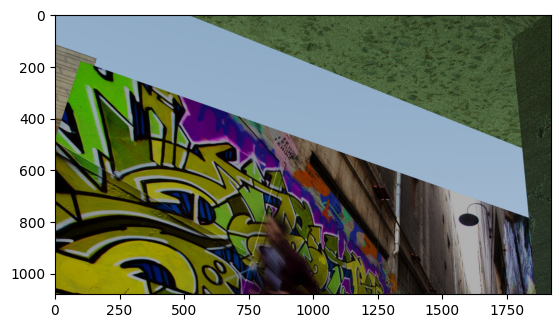

In [7]:
#Printing the training image

#image
print(ftrain.iloc[3])
image = mpimg.imread(ftrain.iloc[3][0])
print(image.shape)
print(type(image))
plt.imshow(image)

image file name                         D:\Saksham\IC-SHM_2021\Tokaidos\img_syn_raw/tr...
component label file name               D:\Saksham\IC-SHM_2021\Tokaidos\synthetic/trai...
damage label file name                  D:\Saksham\IC-SHM_2021\Tokaidos\synthetic/trai...
depth image file name                   D:\Saksham\IC-SHM_2021\Tokaidos\synthetic/trai...
camera focal length in mm                                                       43.242723
regular images                                                                       True
images containing damage in the RRDR                                                 True
Name: 3, dtype: object
(360, 640)
<class 'numpy.ndarray'>


C:\Users\REP_SIF_2\AppData\Local\Temp\ipykernel_26048\3324667387.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image = mpimg.imread(ftrain.iloc[3][3])#[x][y] x = row no. & y = {0:raw image, 1:component label, 2:damage label, 3:depth label}


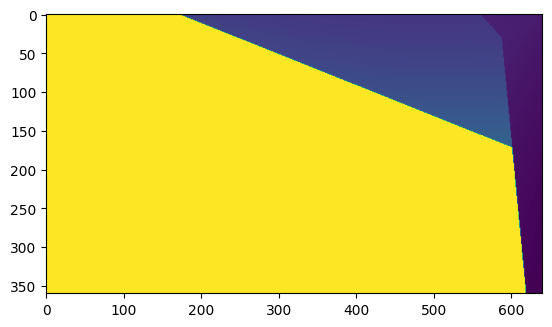

In [8]:
#label
#Printing the above image label
print(ftrain.iloc[3])
image = mpimg.imread(ftrain.iloc[3][3])#[x][y] x = row no. & y = {0:raw image, 1:component label, 2:damage label, 3:depth label}
print(image.shape)
print(type(image))
plt.imshow(image)

In [9]:
#Run for training on the damage images
train1 = train_dmg[:4000]
val1 = train_dmg[4000:]

image file name           D:\Saksham\IC-SHM_2021\Tokaidos\images_puretex...
damage label file name    D:\Saksham\IC-SHM_2021\Tokaidos\synthetic_pure...
Name: 0, dtype: object


C:\Users\REP_SIF_2\AppData\Local\Temp\ipykernel_26048\792360932.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image = mpimg.imread(ftrain.iloc[0][1])


(360, 640)
<class 'numpy.ndarray'>


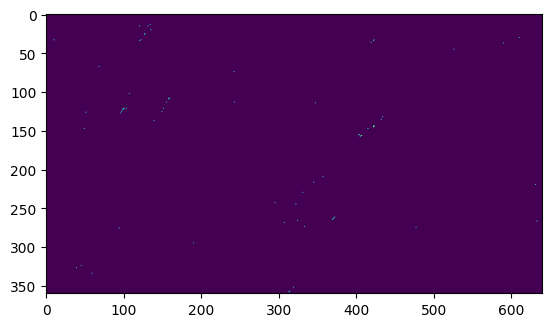

In [10]:
#Loading the training data from the pure_tex file

#Access the csv file containing the absolute directory paths to each file
path_ds = 'D:\Saksham\IC-SHM_2021\Tokaidos' #put a path to the dataset
col_names = ['image file name', 'damage label file name']

ftrain = pd.read_csv(os.path.join(path_ds,'files_puretex_train.csv'),names = col_names,delimiter=',')
ftrain.iloc[:,0] = ftrain.iloc[:,0].apply(lambda x: path_correct(x))
ftrain.iloc[:,1] = ftrain.iloc[:,1].apply(lambda x: path_correct(x))

train_tex = ftrain

#Printing the training image
print(ftrain.iloc[0])
image = mpimg.imread(ftrain.iloc[0][1])
print(image.shape)
print(type(image))
plt.imshow(image)

In [11]:
print(len(train_tex))
train_tex

2700


,image file name,damage label file name
0,D:\Saksham\IC-SHM_2021\Tokaidos\images_puretex...,D:\Saksham\IC-SHM_2021\Tokaidos\synthetic_pure...
1,D:\Saksham\IC-SHM_2021\Tokaidos\images_puretex...,D:\Saksham\IC-SHM_2021\Tokaidos\synthetic_pure...
2,D:\Saksham\IC-SHM_2021\Tokaidos\images_puretex...,D:\Saksham\IC-SHM_2021\Tokaidos\synthetic_pure...
3,D:\Saksham\IC-SHM_2021\Tokaidos\images_puretex...,D:\Saksham\IC-SHM_2021\Tokaidos\synthetic_pure...
4,D:\Saksham\IC-SHM_2021\Tokaidos\images_puretex...,D:\Saksham\IC-SHM_2021\Tokaidos\synthetic_pure...
...,...,...
2695,D:\Saksham\IC-SHM_2021\Tokaidos\images_puretex...,D:\Saksham\IC-SHM_2021\Tokaidos\synthetic_pure...
2696,D:\Saksham\IC-SHM_2021\Tokaidos\images_puretex...,D:\Saksham\IC-SHM_2021\Tokaidos\synthetic_pure...
2697,D:\Saksham\IC-SHM_2021\Tokaidos\images_puretex...,D:\Saksham\IC-SHM_2021\Tokaidos\synthetic_pure...
2698,D:\Saksham\IC-SHM_2021\Tokaidos\images_puretex...,D:\Saksham\IC-SHM_2021\Tokaidos\synthetic_pure...


In [12]:
# Append the first 2300 rows from 'train_tex' to 'train1'
train1 = pd.concat([train1, train_tex[:2300]])

# Append the remaining rows from 'train_tex' to 'val1'
val1 = pd.concat([val1, train_tex[2300:]])

### DATA PREPROSSessing 

In [13]:
# Function to get label for an image
def get_label(mask):
    mask = np.squeeze(mask)
    target_array = np.zeros((mask.shape[0], mask.shape[1], 3))
    target_array[:, :, 0] = np.where(mask == 1, 1, 0)
    target_array[:, :, 1] = np.where(mask == 2, 1, 0)
    target_array[:, :, 2] = np.where(mask == 3, 1, 0)

    return target_array

# Function to show image
def show_img(image):
    plt.figure()
    plt.imshow(image)
    plt.axis('off')

# Function to show labels
def show_label(label):
    fig, axes = plt.subplots(1, 3, figsize=(16, 112))
    y1 = label[:, :, 0]
    y2 = label[:, :, 1]
    y3 = label[:, :, 2]
    axes[0].imshow(y1)
    axes[1].imshow(y2)
    axes[2].imshow(y3)
    for ax in axes:
        ax.axis('off')

# Function to show predictions
def show_pred(y, threshold=0.5):
    fig, axes = plt.subplots(1, 3, figsize=(16, 112))
    y1 = y[:, :, 0]
#    y2 = y[:, :, 1]
#   y3 = y[:, :, 2]
    axes[0].imshow(y1)
#    axes[1].imshow(y2)
#    axes[2].imshow(y3)
    for ax in axes:
        ax.axis('off')

# Function to normalize image
def normalize(input_image):
    return input_image / 255.0

# Function to augment image with random horizontal flip
def image_augmentation(img):
    if random.random() > 0.5:
        img = transforms.functional.hflip(img)
    return img

# Function to augment label with random horizontal flip
def label_augmentation(label):
    if random.random() > 0.5:
        label = transforms.functional.hflip(label)
    return label

# Preprocess function to load and preprocess images and masks
def preprocess(x, y):
    # Load image and mask
    image = Image.open(x).convert("RGB")
    mask = Image.open(y)
    
    # Resize and normalize image
    transform_image = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Lambda(normalize)
    ])
    image = transform_image(image)

    # Resize and process mask
    mask = mask.resize((64, 64))
    mask = np.array(mask)
    mask = get_label(mask) 
    # Convert mask to tensor
    mask = torch.tensor(mask, dtype=torch.float32).permute(2, 0, 1)  # [C, H, W] 

    # Apply augmentations
    image = image_augmentation(image)
    mask = label_augmentation(mask)

    return image, mask


In [14]:
# Extract image and mask file paths from the CSV file
train_image_paths = train1['image file name'].values
train_mask_paths = train1['damage label file name'].values

val_image_paths = val1['image file name'].values
val_mask_paths = val1['damage label file name'].values

In [15]:
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class Dataset(Dataset):
    def __init__(self, img_path, label_path, image_transform=None, mask_transform=None):
        self.img_path = img_path
        self.label_path = label_path
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.img_path)

    def __getitem__(self, idx):

        # Load image and mask
        image = Image.open(self.img_path[idx]).convert('RGB')
        mask = Image.open(self.label_path[idx])

        # Apply image transformations and augmentations
        if self.image_transform:
            image = self.image_transform(image)
        
        # Apply mask transformations
        if self.mask_transform:
            mask = self.mask_transform(mask)
    
        return image, mask

# Define separate transformations for images and masks
image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

mask_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  # Convert mask to tensor but no normalization
])

In [16]:
# Create datasets
train_dataset = Dataset(
    img_path=train_image_paths, 
    label_path=train_mask_paths, 
    image_transform=image_transform, 
    mask_transform=mask_transform
)

val_dataset = Dataset(
    img_path=val_image_paths, 
    label_path=val_mask_paths, 
    image_transform=image_transform, 
    mask_transform=mask_transform
)
# DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [17]:
# Inception Model for FID calculation (used in eval mode)
inception_model = inception_v3(pretrained=True, transform_input=False).eval().to(device)

D:\Anaconda\envs\tf-gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Anaconda\envs\tf-gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
len(train_dataset)

6300

In [19]:
len(val_dataset)

781

Image shape: torch.Size([3, 64, 64])
Mask shape: torch.Size([1, 64, 64])


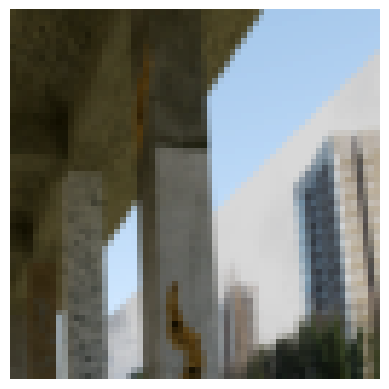

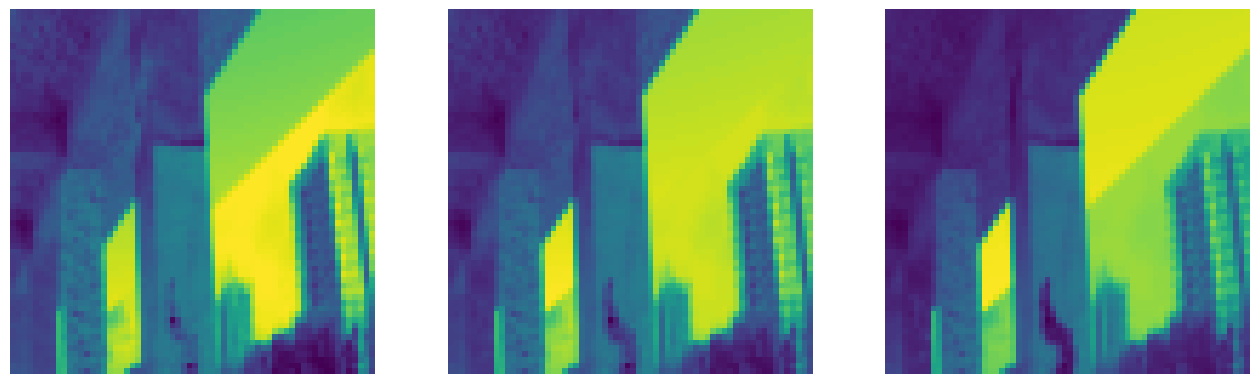

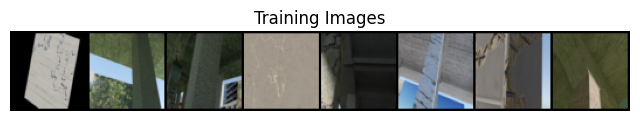

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torchvision.utils as vutils
# Loop through the dataset
for img, mask in val_dataset:
    # Convert tensors to NumPy arrays and normalize if needed
    img_np = img.permute(1, 2, 0).numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())  # Normalize to [0, 1]

    mask_np = mask.permute(1, 2, 0)
    
    # Print shapes for debugging
    print(f"Image shape: {img.shape}")
    print(f"Mask shape: {mask.shape}")
    
    # Show image and mask
    show_img(img_np)
    show_label(img_np)
    break

# Plot some training images
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()


### Model

In [21]:
# Device setup
device = "cuda" if torch.cuda.is_available() else "cpu"

# Hyperparameters
LEARNING_RATE = 1e-4
BATCH_SIZE = 8
IMAGE_SIZE = 64
CHANNELS_IMG = 3
Z_DIM = 100
NUM_EPOCHS = 100
FEATURES_CRITIC = 16
FEATURES_GEN = 16
CRITIC_ITERATIONS = 2
LAMBDA_GP = 10

In [22]:
# Gradient Penalty
def gradient_penalty(critic, real, fake, device="cuda"):
    batch_size, C, H, W = real.size()
    epsilon = torch.rand(batch_size, 1, 1, 1).to(device)
    interpolated_images = epsilon * real + (1 - epsilon) * fake
    interpolated_images.requires_grad_(True)

    interpolated_scores = critic(interpolated_images)
    gradients = grad(
        outputs=interpolated_scores,
        inputs=interpolated_images,
        grad_outputs=torch.ones_like(interpolated_scores).to(device),
        create_graph=True,
        retain_graph=True,
    )[0]
    
    gradients = gradients.view(batch_size, -1)
    gradient_norm = gradients.norm(2, dim=1)
    penalty = ((gradient_norm - 1) ** 2).mean()
    return penalty

In [23]:
# Self-Attention Layer
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        self.ch_query = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.ch_key = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.ch_value = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.ch_out = nn.Conv2d(in_channels, in_channels, kernel_size=1)

    def forward(self, x):
        batch_size, C, H, W = x.size()
        query = self.ch_query(x).view(batch_size, C // 8, -1)  # (N, C//8, H*W)
        key = self.ch_key(x).view(batch_size, C // 8, -1)  # (N, C//8, H*W)
        value = self.ch_value(x).view(batch_size, C, -1)  # (N, C, H*W)
        
        attention = torch.bmm(query.permute(0, 2, 1), key)  # (N, H*W, H*W)
        attention = torch.nn.functional.softmax(attention, dim=-1)
        
        out = torch.bmm(value, attention)  # (N, C, H*W)
        out = out.view(batch_size, C, H, W)
        return self.ch_out(out)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=1, padding=0),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)

# Generator
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            self._block(channels_noise, features_g * 16, 4, 1, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            SelfAttention(features_g * 2),  # Self-Attention Layer
            nn.ConvTranspose2d(features_g * 2, channels_img, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),  # Output: N x channels_img x 64 x 64
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)

# Weight Initialization
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

# Test Function
def test():
    N, in_channels, H, W = BATCH_SIZE, CHANNELS_IMG, IMAGE_SIZE, IMAGE_SIZE
    noise_dim = Z_DIM
    x = torch.randn((N, in_channels, H, W))
    disc = Discriminator(in_channels, FEATURES_CRITIC)
    assert disc(x).shape == (N, 1, 1, 1), "Discriminator test failed"
    gen = Generator(noise_dim, in_channels, FEATURES_GEN)
    z = torch.randn((N, noise_dim, 1, 1))
    assert gen(z).shape == (N, in_channels, H, W), "Generator test failed"

In [24]:
# Model Initialization
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
critic = Discriminator(CHANNELS_IMG, FEATURES_CRITIC).to(device)
initialize_weights(gen)
initialize_weights(critic)

In [25]:
# Optimizers
optimizer_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
optimizer_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

In [27]:
# FID Calculation Function
def calculate_fid(real_images, fake_images, inception_model):
    # Preprocess real and fake images for InceptionV3 (resize to 299x299)
    real_images_resized = F.interpolate(real_images, size=(299, 299), mode='bilinear', align_corners=False)
    fake_images_resized = F.interpolate(fake_images, size=(299, 299), mode='bilinear', align_corners=False)

    # Extract features using the Inception model
    real_features = inception_model(real_images_resized).detach().cpu().numpy()
    fake_features = inception_model(fake_images_resized).detach().cpu().numpy()

    # Calculate the mean and covariance of real and fake images
    mu_real, sigma_real = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu_fake, sigma_fake = fake_features.mean(axis=0), np.cov(fake_features, rowvar=False)

    # Calculate the FID score
    diff = mu_real - mu_fake
    covmean, _ = sqrtm(sigma_real.dot(sigma_fake), disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = diff.dot(diff) + np.trace(sigma_real + sigma_fake - 2 * covmean)
    return fid

# Training Loop
for epoch in range(NUM_EPOCHS):
    for i, (real, _) in enumerate(train_loader):
        real = real.to(device)
        batch_size = real.size(0)

        # Training Critic
        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn(batch_size, Z_DIM, 1, 1).to(device)
            fake = gen(noise)

            optimizer_critic.zero_grad()

            # Train on real images
            output_real = critic(real).view(-1)
            d_loss_real = -torch.mean(output_real)

            # Train on fake images
            output_fake = critic(fake.detach()).view(-1)
            d_loss_fake = torch.mean(output_fake)

            # Gradient Penalty
            gp = gradient_penalty(critic, real, fake, device)
            d_loss = d_loss_real + d_loss_fake + LAMBDA_GP * gp
            d_loss.backward()
            optimizer_critic.step()

        # Training Generator
        optimizer_gen.zero_grad()
        noise = torch.randn(batch_size, Z_DIM, 1, 1).to(device)
        fake = gen(noise)
        output_fake = critic(fake).view(-1)
        g_loss = -torch.mean(output_fake)
        g_loss.backward()
        optimizer_gen.step()

        # Print losses every few iterations
        if i % 200 == 0:
            print(f'Epoch [{epoch}/{NUM_EPOCHS}], Step [{i}/{len(train_loader)}], C_Loss: {d_loss.item()}, G_Loss: {g_loss.item()}')

    # Calculate and print FID every epochs
    if epoch % 1 == 0:
        gen.eval()
        real_images = next(iter(train_loader))[0].to(device)
        noise = torch.randn(batch_size, Z_DIM, 1, 1).to(device)
        fake_images = gen(noise)
        fid_score = calculate_fid(real_images, fake_images, inception_model)
        print(f"Epoch [{epoch}/{NUM_EPOCHS}] - FID Score: {fid_score:.4f}")
        gen.train()

    # Save generated images and models after each epoch
    if epoch % 5 == 0:
        with torch.no_grad():
            fake_images = gen(noise).detach().cpu()
            save_image(fake_images[:], f"generated_images/SAwgan1_images_epoch{epoch}.png", nrow=5, normalize=True)

        # Save the model
        torch.save(gen.state_dict(), f"generator_epoch_{epoch}.pth")
        torch.save(critic.state_dict(), f"critic_epoch_{epoch}.pth")

Epoch [0/100], Step [0/788], C_Loss: 47.50324630737305, G_Loss: 0.5697567462921143
Epoch [0/100], Step [200/788], C_Loss: -3.1581926345825195, G_Loss: 5.668854713439941
Epoch [0/100], Step [400/788], C_Loss: -6.995041847229004, G_Loss: 9.204832077026367
Epoch [0/100], Step [600/788], C_Loss: -13.86041259765625, G_Loss: 6.9277544021606445
Epoch [0/100] - FID Score: 1929.4388
Epoch [1/100], Step [0/788], C_Loss: -10.082743644714355, G_Loss: 12.181680679321289
Epoch [1/100], Step [200/788], C_Loss: 0.5846973061561584, G_Loss: -22.122234344482422
Epoch [1/100], Step [400/788], C_Loss: -8.639633178710938, G_Loss: 3.700564384460449
Epoch [1/100], Step [600/788], C_Loss: -1.412980318069458, G_Loss: -2.1166176795959473
Epoch [1/100] - FID Score: 2180.1452
Epoch [2/100], Step [0/788], C_Loss: -8.951811790466309, G_Loss: -3.3886823654174805
Epoch [2/100], Step [200/788], C_Loss: -7.497128963470459, G_Loss: 1.502142071723938
Epoch [2/100], Step [400/788], C_Loss: -7.958927154541016, G_Loss: 5.572

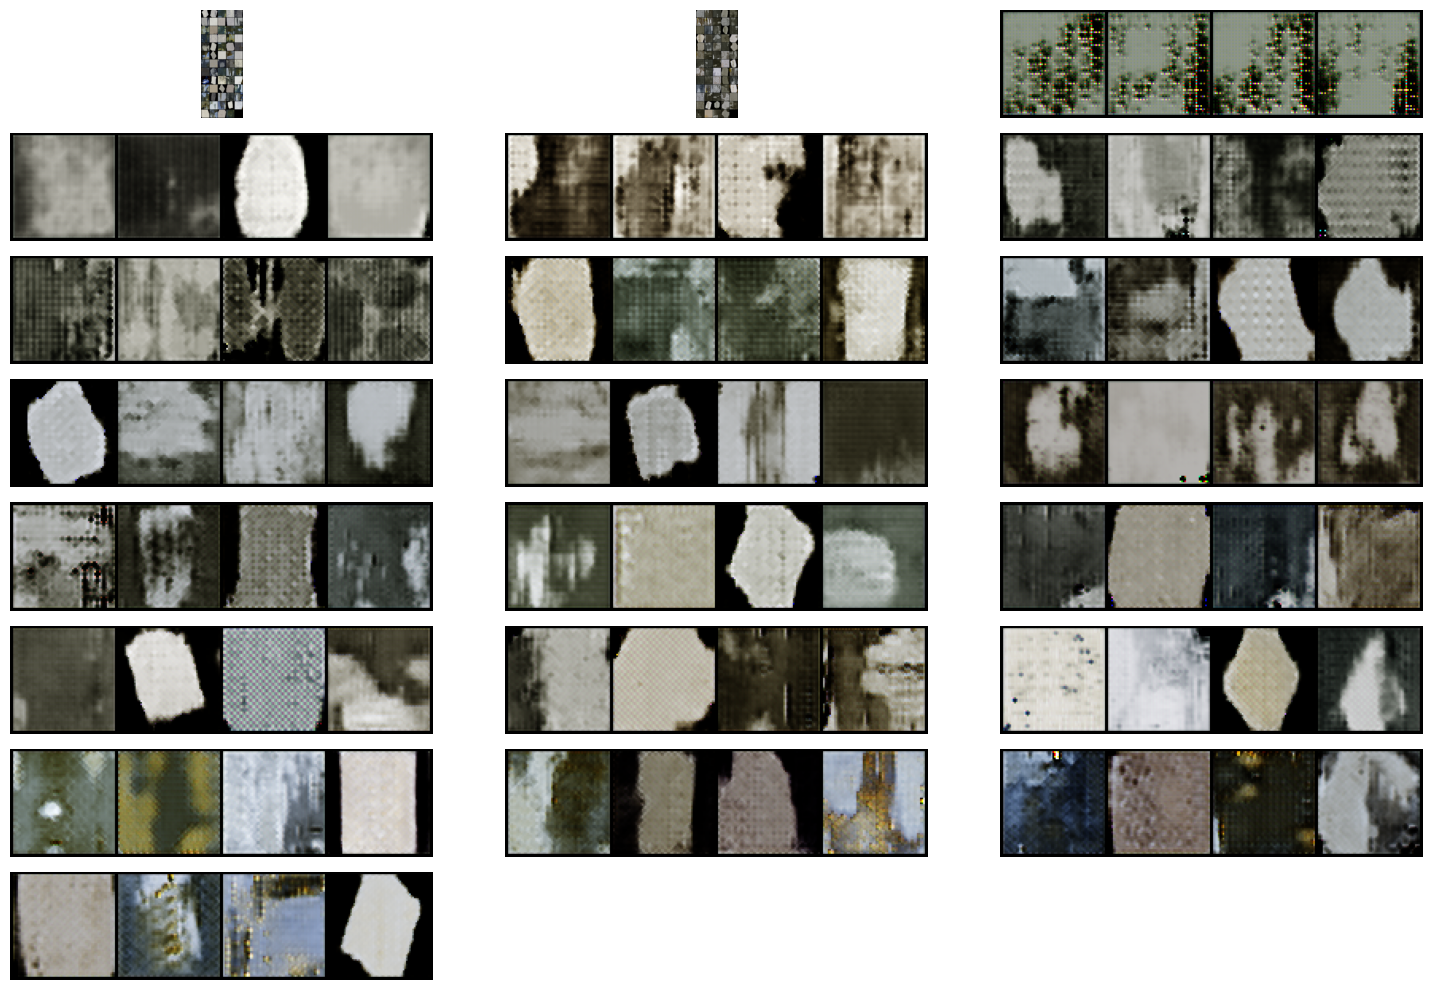

In [34]:
import os
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display

# Define the path to the folder containing images
folder_path = 'generated_images'

# List all files in the folder
image_files = [f for f in os.listdir(folder_path) if f.endswith(('png', 'jpg', 'jpeg', 'gif'))]

# Create a figure with a grid of subplots
plt.figure(figsize=(15, 10))

for i, image_file in enumerate(image_files):
    # Open an image file
    image_path = os.path.join(folder_path, image_file)
    img = Image.open(image_path)
    
    # Create subplot
    plt.subplot(len(image_files) // 3 + 1, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')  # Hide axis

plt.tight_layout()
plt.show()